### Bayesian optimization from scratch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

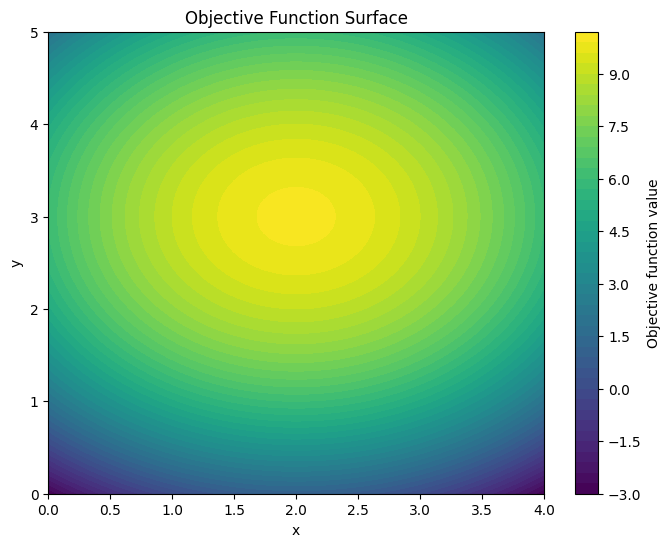

In [1]:


# Funzione obiettivo: questa è quella che vogliamo massimizzare
def objective_function(x, y):
    return -(x - 2)**2 - (y - 3)**2 + 10

# Visualizziamo la funzione obiettivo per avere un'idea
x = np.linspace(0, 4, 100)
y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)
Z = objective_function(X, Y)

plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Objective function value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Objective Function Surface')
plt.show()

In [2]:
# Funzione kernel: misura la "similarità" tra i punti
def kernel(X1, X2, length_scale=1.0, sigma_f=1.0):
    """ Squared Exponential kernel (Gaussian Kernel) """
    sqdist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / length_scale**2 * sqdist)

# GP predizione
def gp_predict(X_train, Y_train, X_new, length_scale=1.0, sigma_f=1.0, sigma_y=1e-8):
    """ Predice la media e la varianza del GP in nuovi punti """
    # Kernel tra i punti di training
    K = kernel(X_train, X_train, length_scale, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    
    # Kernel tra i punti di training e i nuovi punti
    K_s = kernel(X_train, X_new, length_scale, sigma_f)
    
    # Kernel tra i nuovi punti
    K_ss = kernel(X_new, X_new, length_scale, sigma_f) + 1e-8 * np.eye(len(X_new))
    
    # Inversione della matrice di covarianza
    K_inv = np.linalg.inv(K)
    
    # Predizione della media
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    
    # Predizione della covarianza
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

# Esempio di dati di training iniziali
X_train = np.array([[1, 1], [2, 2], [3, 3]])
Y_train = objective_function(X_train[:, 0], X_train[:, 1])

# Nuovi punti dove fare predizioni
X_new = np.array([[1.5, 2.5], [2.5, 3.5]])

# Facciamo la predizione con il GP
mu_s, cov_s = gp_predict(X_train, Y_train, X_new)

print("Predizioni GP (media):", mu_s)
print("Incertezza (deviazione standard):", np.sqrt(np.diag(cov_s)))

Predizioni GP (media): [7.00920705 7.00920705]
Incertezza (deviazione standard): [0.62727135 0.62727135]


In [3]:
from scipy.stats import norm

def expected_improvement(X_new, X_train, Y_train, xi=0.01):
    """ Expected Improvement (EI) per nuovi punti """
    mu_s, cov_s = gp_predict(X_train, Y_train, X_new)
    sigma_s = np.sqrt(np.diag(cov_s))

    Y_best = np.max(Y_train)  # Il miglior risultato osservato finora
    
    # Formula dell'EI
    with np.errstate(divide='warn'):
        imp = mu_s - Y_best - xi
        Z = imp / sigma_s
        ei = imp * norm.cdf(Z) + sigma_s * norm.pdf(Z)
        ei[sigma_s == 0.0] = 0.0

    return ei

# Calcoliamo l'EI per i nuovi punti
ei_values = expected_improvement(X_new, X_train, Y_train)
print("Expected Improvement (EI) values:", ei_values)

Expected Improvement (EI) values: [0.00012073 0.00012073]


In [5]:
def bayesian_optimization(n_iters, X_train, Y_train, bounds, xi=0.01):
    for i in range(n_iters):
        # Troviamo nuovi punti usando l'EI
        X_new = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(100, X_train.shape[1]))
        ei = expected_improvement(X_new, X_train, Y_train, xi=xi)
        
        # Scegliamo il punto con il massimo EI
        X_next = X_new[np.argmax(ei)]
        
        # Valutiamo la funzione obiettivo in questo nuovo punto
        Y_next = objective_function(X_next[0], X_next[1])
        
        # Aggiorniamo i dati di training
        X_train = np.vstack((X_train, X_next))
        Y_train = np.append(Y_train, Y_next)
        
        print(f"Iterazione {i+1}: miglioramento atteso {np.max(ei)}, nuovo punto {X_next}")
    
    return X_train, Y_train

# Limiti dei parametri (x e y)
bounds = np.array([[0, 4], [0, 5]])

# Lanciamo la Bayesian Optimization
X_train, Y_train = bayesian_optimization(n_iters=50, X_train=X_train, Y_train=Y_train, bounds=bounds)

Iterazione 1: miglioramento atteso 1.5157757082015776e-05, nuovo punto [2.1242236  2.79921625]
Iterazione 2: miglioramento atteso 3.7125938054295683e-09, nuovo punto [1.57736058 3.07273702]
Iterazione 3: miglioramento atteso 0.024857636680764364, nuovo punto [2.00370772 3.02396039]
Iterazione 4: miglioramento atteso 1.347861482029634e-08, nuovo punto [1.62865846 3.4030337 ]
Iterazione 5: miglioramento atteso 1.6415449883699702e-13, nuovo punto [1.48455145 2.56804046]
Iterazione 6: miglioramento atteso 1.5061995307187966e-16, nuovo punto [2.25833973 4.54426925]
Iterazione 7: miglioramento atteso 9.576102846442807e-16, nuovo punto [1.22390876 4.77600797]
Iterazione 8: miglioramento atteso 5.561679788823088e-16, nuovo punto [0.37602485 3.21614638]
Iterazione 9: miglioramento atteso 4.380308868544191e-16, nuovo punto [2.02488346 3.18858287]
Iterazione 10: miglioramento atteso 1.0852445720674808e-16, nuovo punto [0.09881039 1.81055683]
Iterazione 11: miglioramento atteso 7.265882005329554e-

### Bayesian optimization

In [1]:
from bayes_opt import BayesianOptimization
import numpy as np
import math

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [2]:
# Funzione obiettivo fittizia per ottimizzare (ad esempio il rendimento della strategia)
def objective_function(param1, param2):
    # Ad esempio, questa è una funzione che stiamo cercando di massimizzare
    return math.sin(param1) + 3*math.cos(param2+param1**param2)
# Definire i limiti per ogni parametro
pbounds = {'param1': (0, 4), 'param2': (0, 5)}

# Creare l'ottimizzatore bayesiano
optimizer = BayesianOptimization(
    f=objective_function,  # La funzione obiettivo da massimizzare
    pbounds=pbounds,       # I limiti dei parametri
    random_state=42        # Per la riproducibilità
)

# Eseguire l'ottimizzazione
optimizer.maximize(
    init_points=2,    # Numero di punti iniziali random
    n_iter=300         # Numero di iterazioni dell'ottimizzatore
)

# Mostra i risultati
print("Miglior risultato trovato:", optimizer.max)

|   iter    |  target   |  param1   |  param2   |
-------------------------------------------------
| 1         | 2.666     | 1.498     | 4.754     |
| 2         | -2.596    | 2.928     | 2.993     |
| 3         | 3.403     | 1.57      | 4.739     |
| 4         | 3.717     | 2.021     | 4.653     |
| 5         | 1.633     | 1.73      | 4.157     |
| 6         | -0.5479   | 1.893     | 5.0       |
| 7         | 1.68      | 1.774     | 4.0       |
| 8         | 2.291     | 2.606     | 1.77      |
| 9         | 3.087     | 1.576     | 4.739     |
| 10        | 3.69      | 1.535     | 4.68      |
| 11        | 2.221     | 2.067     | 4.585     |
| 12        | 1.933     | 2.152     | 1.621     |
| 13        | -0.119    | 1.947     | 4.666     |
| 14        | -1.99     | 2.072     | 4.678     |
| 15        | 3.854     | 1.535     | 4.716     |
| 16        | 3.884     | 1.547     | 4.783     |
| 17        | -0.357    | 2.007     | 4.609     |
| 18        | 3.754     | 1.569     | 4.695     |


In [5]:
# Funzione obiettivo fittizia per ottimizzare (ad esempio il rendimento della strategia)
def objective_function(param1, param2, param_bool):
    # Arrotondamento per i parametri interi e booleani
    param2 = round(param2)  # Parametro intero
    param_bool = 1 if param_bool > 0.5 else 0  # Parametro booleano (trasformiamo in 0/1)
    
    # La funzione obiettivo considera sia parametri continui che discreti
    return -(param1 - 2)**2 - (param2 - 3)**2 + (5 * param_bool) + 10

# Definire i limiti per ogni parametro
pbounds = {
    'param1': (0, 4),  # Continuo
    'param2': (0, 5),  # Intero, ma trattato come continuo nel modello
    'param_bool': (0, 1)  # Booleano (0 o 1)
}

# Creare l'ottimizzatore bayesiano
optimizer = BayesianOptimization(
    f=objective_function,  # La funzione obiettivo da massimizzare
    pbounds=pbounds,       # I limiti dei parametri
    random_state=42        # Per la riproducibilità
)

# Eseguire l'ottimizzazione con arrotondamento dei parametri interi/booleani
optimizer.maximize(
    init_points=2,    # Numero di punti iniziali random
    n_iter=100         # Numero di iterazioni dell'ottimizzatore
)

# Mostra i risultati
print("Miglior risultato trovato:", optimizer.max)

|   iter    |  target   |  param1   |  param2   | param_... |
-------------------------------------------------------------
| 1         | 10.75     | 1.498     | 4.754     | 0.732     |
| 2         | 5.844     | 2.395     | 0.7801    | 0.156     |
| 3         | 10.69     | 1.447     | 4.702     | 0.73      |
| 4         | 2.0       | 4.0       | 5.0       | 0.0       |
| 5         | 2.0       | 0.0       | 5.0       | 0.0       |
| 6         | 13.99     | 2.095     | 3.951     | 1.0       |
| 7         | 14.84     | 1.604     | 2.843     | 1.0       |
| 8         | 10.0      | 0.0       | 1.886     | 1.0       |
| 9         | 14.14     | 2.928     | 2.743     | 1.0       |
| 10        | 9.984     | 2.126     | 3.059     | 0.0       |
| 11        | 10.0      | 4.0       | 1.74      | 1.0       |
| 12        | 2.0       | 0.0       | 0.0       | 1.0       |
| 13        | 13.97     | 2.165     | 2.203     | 1.0       |
| 14        | 14.95     | 2.22      | 3.056     | 1.0       |
| 15    